In [1]:
# If running on Colab, uncomment the next lines
# %tensorflow_version 2.x
# device_name = tf.test.gpu_device_name()
# print('GPU not found.') if device_name != '/device:GPU:0' else print('Found GPU at: {}'.format(device_name))

In [2]:
import tensorflow as tf
from utils.dataset_functions import create_dataset, unwrap_client_data
from utils.image_processing import *
from utils.unet import initialize_unet
from utils.federated_averaging import federated_averaging
from utils.visualization import visualize_results_testset

In [3]:
imagePath0 = 'data/Laser Powder Bed Fusion/0/' # Post Spreading Images
imagePath1 = 'data/Laser Powder Bed Fusion/1/' # Post Fusion Images
npyPath = 'data/Laser Powder Bed Fusion/annotations/' # Annotations

clientIdentifierDict = {
    'client1' : ['0000004', '0000017', '0000018'],
    'client2' : ['0000010', '0000011', '0000015'],
    'client3' : ['0000020', '0000021', '0000022'],
    'client4' : ['0000006', '0000033'],
    'client5' : ['0000014', '0000019', '0000161', '0000216'],
    'client6' : ['0000007', '0000008'],
    'client7' : ['0000012', '0000013'],
    'client8' : ['0000016']
}

datasetImageDict, datasetMaskDict = create_dataset(clientIdentifierDict, 
                                             imagePath0, imagePath1, npyPath, 
                                             tileSize = 128)


client1...
Contains 3 images...
Tiled Image Tensor Shape:  (972, 128, 128, 2)
Tiled Mask Shape:  (972, 128, 128)

client2...
Contains 3 images...
Tiled Image Tensor Shape:  (972, 128, 128, 2)
Tiled Mask Shape:  (972, 128, 128)

client3...
Contains 3 images...
Tiled Image Tensor Shape:  (972, 128, 128, 2)
Tiled Mask Shape:  (972, 128, 128)

client4...
Contains 2 images...
Tiled Image Tensor Shape:  (648, 128, 128, 2)
Tiled Mask Shape:  (648, 128, 128)

client5...
Contains 4 images...
Tiled Image Tensor Shape:  (1066, 128, 128, 2)
Tiled Mask Shape:  (1066, 128, 128)

client6...
Contains 2 images...
Tiled Image Tensor Shape:  (648, 128, 128, 2)
Tiled Mask Shape:  (648, 128, 128)

client7...
Contains 2 images...
Tiled Image Tensor Shape:  (648, 128, 128, 2)
Tiled Mask Shape:  (648, 128, 128)

client8...
Contains 1 images...
Tiled Image Tensor Shape:  (324, 128, 128, 2)
Tiled Mask Shape:  (324, 128, 128)


In [4]:
trainClients = ['client1', 'client2', 'client3', 'client4', 
                'client5', 'client7', 'client8']
testClients = ['client6']

clientIDs, NCLIENTS = trainClients, len(trainClients)

Client Data is stored in two separate dictionaries, one for tiled image tensors (X) and other for segmentation masks (Y). Both dictionaries are keyed by `clientID`.

Training Dictionaries - `imageDict`(X) and `segMaskDict`(Y)

Testing Dictionaries - `imageDictTest`(X) and `segMaskDictTest`(Y)

In [5]:
# Train Data
imageDict, segMaskDict = {}, {}
for clientID in trainClients:
    imageDict[clientID] = datasetImageDict[clientID]
    segMaskDict[clientID] = datasetMaskDict[clientID]

# Test Data
imageDictTest, segMaskDictTest = {}, {}
for clientID in testClients:
    imageDictTest[clientID] = datasetImageDict[clientID]
    segMaskDictTest[clientID] = datasetMaskDict[clientID]
# unwrap test data from dictionary for easier model evaluation
testImages, testMasks = unwrap_client_data(imageDictTest, segMaskDictTest, testClients)

In [6]:
# Set hyperparameters for FL
# For demonstration, we use only 2 server rounds with 5 local epochs
SERVER_ROUNDS, LOCAL_EPOCHS, LOCAL_BATCH_SIZE, LOCAL_LEARNING_RATE = 2, 5, 32, 8e-05

# Initialize the global model
model = initialize_unet()

Model: "u-net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        608 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 256) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 512) │  1,180,160 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 4, 4, 512) │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 8, 8, 512) │          0 │ max_pooling2d_4[… │
│ (UpSampling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 512) │    262,656 │ up_sampling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 8,      │          0 │ conv2d_5[0][0],   │
│ (Concatenate)       │ 1024)             │            │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 8, 8, 512) │  4,719,104 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    131,328 │ up_sampling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 16, 16,    │          0 │ conv2d_7[0][0], 

 Total params: 8,291,907 (31.63 MB)

 Trainable params: 8,291,907 (31.63 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Run (simulate) FL
# Please use GPU/Colab to avoid very long training time
# https://colab.research.google.com/notebooks/intro.ipynb?utm_source=scs-index
# https://colab.research.google.com/notebooks/gpu.ipynb

model, serverWeights, lossDict, testLoss, accuracyDict, testAccuracy = federated_averaging(model,
                        SERVER_ROUNDS, LOCAL_EPOCHS, LOCAL_BATCH_SIZE,
                        LOCAL_LEARNING_RATE,
                        clientIDs, imageDict, segMaskDict,
                        testImages, testMasks)

------ Server Epoch 0 ------
Running local updates for client1...
Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9004 - loss: 0.7193
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9304 - loss: 0.3707
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9304 - loss: 0.3307
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9304 - loss: 0.2753
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9304 - loss: 0.2361
Saving local updates for client1...
Running local updates for client2...
Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.7740 - loss: 0.8964
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.7957 - loss: 0.6587
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.7969 - loss: 0.5025
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.8700 - loss: 0.4293
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8726 - loss: 0.3814
Saving local updates for client

KeyboardInterrupt: 

For client6...
0000007
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 310ms/step
MeanIoU= 0.775


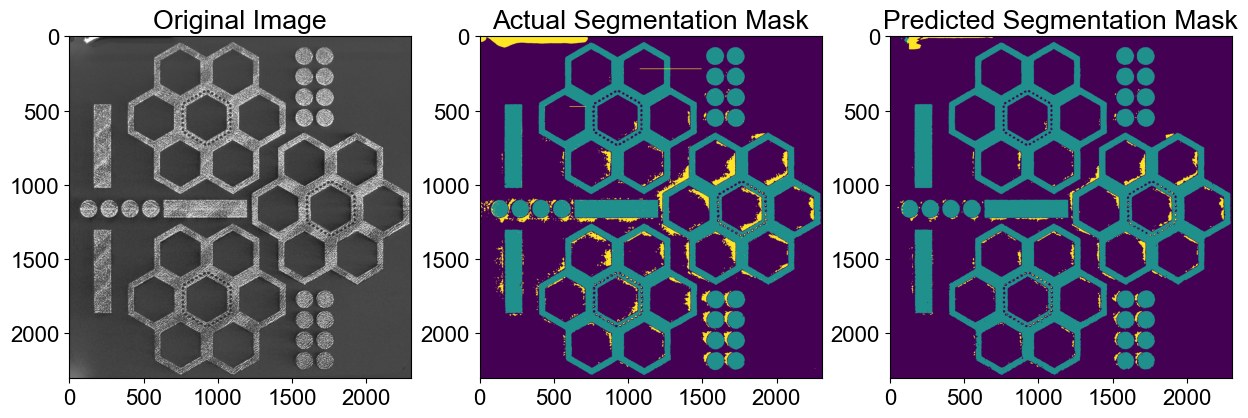

0000008
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 278ms/step
MeanIoU= 0.837


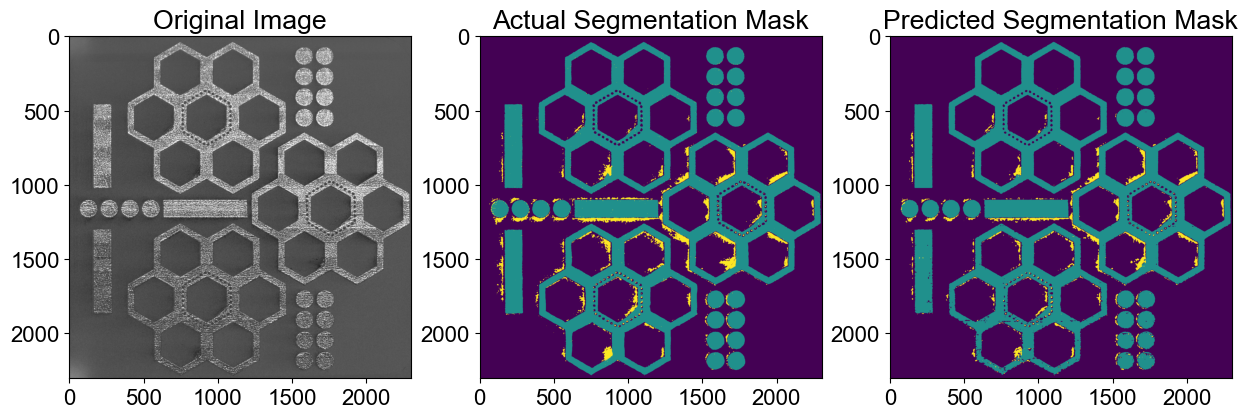

In [9]:
# Visualize results

# Since a well-trained model is available, we use it for demonstration.
fl_model = tf.keras.models.load_model('saved_models/FL_30_10_32_8e05_HoldoutPart0708.h5', compile=False)

visualize_results_testset(fl_model, imageDictTest, segMaskDictTest,
                              testClients, clientIdentifierDict)